# Impact on Housing and Community

This notebook shows an analysis of the impact of the war on Gaza for housing and communities. This is done using the following indicators as of February 2nd, 2024 

* Percentage of damaged residential buildings
* Percentage of people living in/near residential buidlings that were damaged
* Percentage of School Damaged
* Places of Public Amenities Damaged
* Percentage of Homes without (observed) Electricity
* Percentage Residential Solar Panels Damaged



In [2]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from palettable.cartocolors.qualitative import Prism_10, Vivid_10
from palettable.tableau import ColorBlind_10, TableauMedium_10

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Percentage of damaged residential buildings in Gaza as of Feb 2nd 2024

In [3]:
# read shapefiles
PSE = geopandas.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm1_pamop_20231019.shp"
)
PSE = geopandas.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm2_pamop_20231019.shp"
)
GAZA = PSE[PSE["ADM1_EN"] == "Gaza Strip"]

In [4]:
BUILDINGS_OSM = geopandas.read_file(
    "../../data/damage_assessment/delivery8_2Feb2024/vectors/2.5sigma/damaged_OSM_buildings_02Feb2024_2_5sigma.shp"
).to_crs("EPSG:4326")

BUILDINGS_OSM = geopandas.sjoin(BUILDINGS_OSM, GAZA)
BUILDINGS_OSM["type"] = BUILDINGS_OSM["type"].fillna("")

# BUILDINGS_MS = geopandas.read_file(
#     "../../data/damage_assessment/delivery8_2Feb2024/vectors/2.5sigma/damaged_Microsoft_buildings_02Feb2024_2_5sigma.shp"
# ).to_crs("EPSG:4326")

# BUILDINGS_MS = geopandas.sjoin(BUILDINGS_MS, GAZA)
# BUILDINGS_MS["type"] = BUILDINGS_OSM["type"].fillna("")

In [64]:
left = (
    BUILDINGS_OSM[BUILDINGS_OSM["_up7mean"] >= 0.2]
    .value_counts(["ADM2_EN", "type"])
    .to_frame("damaged")
)
right = BUILDINGS_OSM.value_counts(["ADM2_EN", "type"]).to_frame("total")

df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
df["perc"] = 100 * df["damaged"] / df["total"]

In [73]:
sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
df['ADM2_EN'] = pd.Categorical(df['ADM2_EN'], categories=sort_order, ordered=True)
df.sort_values(by='ADM2_EN', inplace=True)

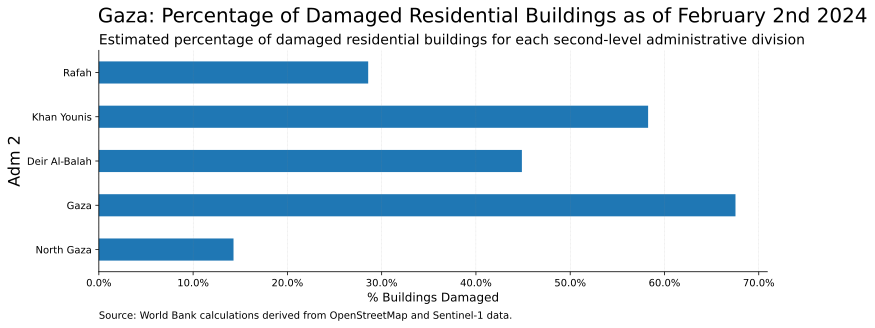

In [88]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.suptitle("Gaza: Percentage of Damaged Residential Buildings as of February 2nd 2024", y=1.03, fontsize=20, x=0.57)

df.pivot_table("perc", "ADM2_EN", "type", observed=False)[
    ["residential"]
].sort_values(by='ADM2_EN').plot(ax=ax, kind="barh", legend = False)

# Add labels and customization
ax.set_xlabel("% Buildings Damaged", fontsize=12)

ax.set_ylabel("Adm 2", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))

ax.grid(axis="x", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
#ax.legend()

ax.set_title(
    "Estimated percentage of damaged residential buildings for each second-level administrative division",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.2,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

### Observations and Limitations

* Nearly 70% of the residential buildings in Gaza are damaged. The attacks on October 7th first started in the Northern parts of Gaza closer to Gaza city. In the OpenStreetMap database, Deir Al-Balah has 439 reported residential buildings. Khan Younis has 242, Gaza has 154, North Gaza has 21 and Rafah has only 7 reported residential buildings. 
* Khan Younis was declared an evacuation zone by the Israeli Armed Forces which could be a potential rason for the high number of damaged buildings. 

## Percentage of Places of Worship Damaged

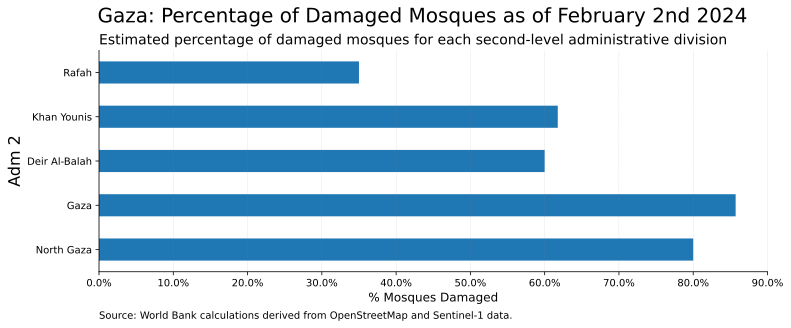

In [89]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.suptitle("Gaza: Percentage of Damaged Mosques as of February 2nd 2024", y=1.03, fontsize=20, x=0.5)

df.pivot_table("perc", "ADM2_EN", "type", observed = False)[
    ["mosque"]
].sort_values(by='ADM2_EN').plot(ax=ax, kind="barh", legend = False)

# Add labels and customization
ax.set_xlabel("% Mosques Damaged", fontsize=12)

ax.set_ylabel("Adm 2", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))

ax.grid(axis="x", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
#ax.legend()

ax.set_title(
    "Estimated percentage of damaged mosques for each second-level administrative division",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.2,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

## Percentage of people who potentially impacted from the damage to residential buildings

In [7]:
from shapely.geometry import Point

def convert_to_gdf(df, X=None, Y=None):
    if 'latitude' in df.columns:
        geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
        gdf = geopandas.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
    else:
        geometry = [Point(xy) for xy in zip(df[Y], df[X])]
        gdf = geopandas.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

In [8]:
POPULATION = pd.read_csv('../../data/population/pse_pd_2020_1km_UNadj_ASCII_XYZ/pse_pd_2020_1km_UNadj_ASCII_XYZ.csv')
POPULATION = convert_to_gdf(POPULATION, 'Y', 'X')

POPULATION = POPULATION.sjoin(GAZA)
POPULATION = POPULATION[POPULATION['ADM1_EN']=='Gaza Strip']

In [9]:
import math
from shapely.geometry import Point, box

# Function to create a 1 km^2 box around a point
def create_square_km_box(point):
    lat, lon = point.y, point.x
    km_in_deg_lat = 1 / 111.32  # 1 km in degrees latitude
    km_in_deg_lon = 1 / (111.32 * math.cos(math.radians(lat)))  # 1 km in degrees longitude at this latitude
    
    # Define the bottom left and top right coordinates of the box
    bottom_left = (lon - km_in_deg_lon / 2, lat - km_in_deg_lat / 2)
    top_right = (lon + km_in_deg_lon / 2, lat + km_in_deg_lat / 2)
    
    # Create and return the box
    return box(*bottom_left, *top_right)


POPULATION['geometry'] = POPULATION['geometry'].apply(create_square_km_box)

c:\Users\sahit\anaconda3\envs\conflict-analyses\lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [102]:
#POPULATION.drop(columns = 'index_right', inplace=True)
#BUILDINGS_OSM.drop(columns = 'index_right', inplace=True)
df = POPULATION[['X', 'Y', 'Z', 'geometry', 'ADM2_EN', 'ADM2_PCODE', 'ADM1_EN',
       'ADM1_PCODE', 'ADM0_EN', 'ADM0_PCODE']].sjoin(BUILDINGS_OSM[BUILDINGS_OSM['type']=='residential'][['osm_id', 'code', 'fclass', 'name', 'type', '_max', 'area','_landusefc', '_up7mean', 'geometry']])

In [103]:
left = POPULATION[['X', 'Y', 'Z', 'ADM2_EN', 'ADM1_EN', 'ADM0_EN']]

right = df[df['type']=='residential'][['X', 'Y', 'Z', '_up7mean']].groupby(['X', 'Y', 'Z']).mean().reset_index()

df = left.merge(right, on = ['X', 'Y', 'Z'])

In [104]:
def damage_ranges(mean):
    if mean<=0.2:
        return 'No damage'
    elif mean>0.2 and mean<=0.4:
        return 'Low damage'
    elif mean>0.4 and mean <=0.6:
        return 'Moderate damage'
    elif mean>0.7:
        return 'High damage'

In [105]:
df['damage_categories'] = df['_up7mean'].apply(lambda x: damage_ranges(x))

In [106]:
df = df.groupby(['ADM0_EN','ADM1_EN','ADM2_EN', 'damage_categories'])[['Z']].sum().reset_index()

In [107]:
sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
df['ADM2_EN'] = pd.Categorical(df['ADM2_EN'], categories=sort_order, ordered=True)
df.sort_values(by='ADM2_EN', inplace=True)

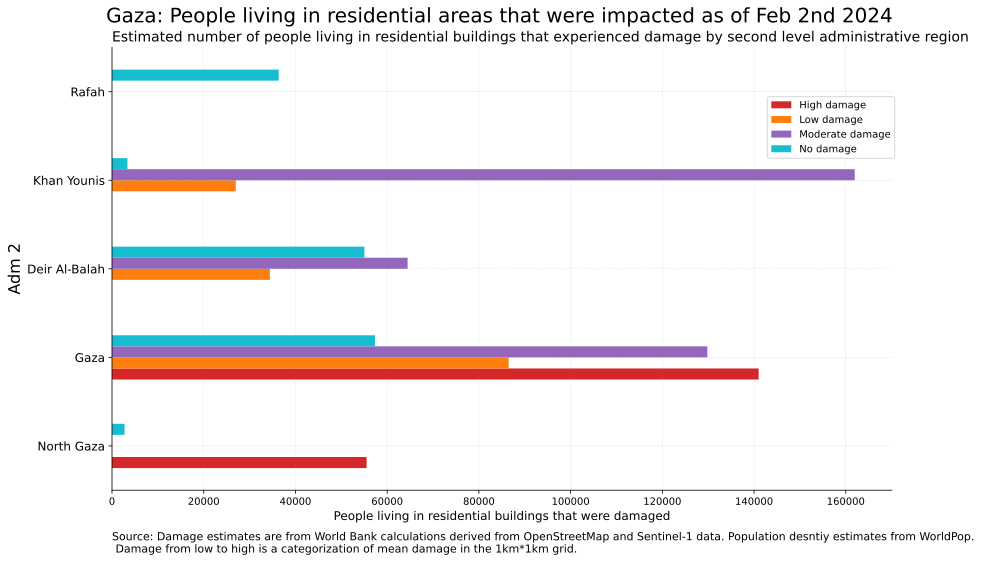

In [109]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.suptitle("Gaza: People living in residential areas that were impacted as of Feb 2nd 2024", y=0.95, fontsize=20, x=0.51)

df[['ADM2_EN', 'damage_categories', 'Z']].pivot_table( 'Z', 'ADM2_EN','damage_categories', observed=False).plot(
    ax=ax, kind="barh", color=['#D62728', '#FF7F0E', '#9467BD', '#17BECF']
)

# Add labels and customization
ax.set_xlabel("People living in residential buildings that were damaged", fontsize=12)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))
ax.set_ylabel("Adm 2", fontsize=16)
ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated number of people living in residential buildings that experienced damage by second level administrative region",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.12,
    "Source: Damage estimates are from World Bank calculations derived from OpenStreetMap and Sentinel-1 data. Population desntiy estimates from WorldPop.\n Damage from low to high is a categorization of mean damage in the 1km*1km grid. ",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=11,
    color="black",
    weight="normal",
);

### Observations 

* Both North Gaza (523k) and Gaza (869k) have higher population than Khan Younis (476k). This is a potential reason for why the damage is higher in Khan Younis but the people impacted are greater in the other two administrative regions.

## Percentage of schools and public amenities damaged

In [92]:
POI = geopandas.read_file(
    "../../data/damage_assessment/delivery8_2Feb2024/vectors/2.5sigma/damaged_pois_1_02Feb2024_2_5sigma.shp"
).to_crs("EPSG:4326")

POI = geopandas.sjoin(POI, GAZA)
POI["fclass"] = POI["fclass"].fillna("")

In [93]:
def get_poi_classification(fclass):
    if fclass in [
        "school",
        "kindergarten",
        "university",
        "college",
    ]:
        return "Education"
    if fclass in [
        "tower",
        "wastewater_plant",
        "water_tower",
        "telephone",
        "water_well",
        "drinking_water",
        "recycling",
    ]:
        return "Infrastructure"
    if fclass in [
        "pharmacy",
        "dentist",
        "doctors",
        "hospital",
        "clinic",
        "nursing_home",
    ]:
        return "Health"
    if fclass in [
        "public_building",
        "police",
        "courthouse",
        "library",
        "monument",
        "post_office",
        "memorial",
        "community_centre",
        "town_hall",
        "museum",
        "arts_centre",
        "sports_centre",
        "tourist_info",
        "fire_station",
    ]:
        return "Public Amenities"

    elif fclass in [
        "clothes",
        "supermarket",
        "restaurant",
        "laundry",
        "cafe",
        "computer_shop",
        "convenience",
        "furniture_shop",
        "shoe_shop",
        "bakery",
        "hotel",
        "hairdresser",
        "fast_food",
        "bank",
        "viewpoint",
        "artwork",
        "picnic_site",
        "chalet",
        "caravan_site",
        "greengrocer",
        "beauty_shop",
        "car_dealership",
        "attraction",
        "pub",
        "waste_basket",
        "nightclub",
        "playground",
        "department_store",
        "outdoor_shop",
        "atm",
        "butcher",
        "car_rental",
        "doityourself",
        "guesthouse",
        "beverages",
        "theatre",
        "newsagent",
        "cinema",
        "mobile_phone_shop",
        "car_wash",
        "bookshop",
        "hostel",
        "sports_shop",
        "castle",
        "pitch",
        "car_sharing",
        "vending_machine",
        "food_court",
        "gift_shop",
        "camp_site",
        "veterinary",
        "post_box",
        "florist",
        "jeweller",
        "chemist",
        "motel",
        "alpine_hut",
        "mall",
        "kiosk",
        "bicycle_shop",
        "bench",
        "optician",
        "travel_agent",
        "biergarten",
        "toy_shop",
        "bar",
        "fountain",
        "archaeological",
        "shelter",
        "park",
        "stationery",
        "market_place",
        "zoo",
    ]:
        return "Places of Economic Activity"

In [94]:
POI["type"] = POI["fclass"].apply(get_poi_classification)

In [112]:
left = POI[POI["_up7max"] >= 0.5].value_counts(["ADM2_EN", "type"]).to_frame("damaged")
right = POI.value_counts(["ADM2_EN", "type"]).to_frame("total")

df = pd.merge(left, right, on=["ADM2_EN", "type"]).reset_index()
df["perc"] = 100 * df["damaged"] / df["total"]

In [113]:
sort_order = ['North Gaza', 'Gaza','Deir Al-Balah', 'Khan Younis', 'Rafah']
df['ADM2_EN'] = pd.Categorical(df['ADM2_EN'], categories=sort_order, ordered=True)
df.sort_values(by='ADM2_EN', inplace=True)

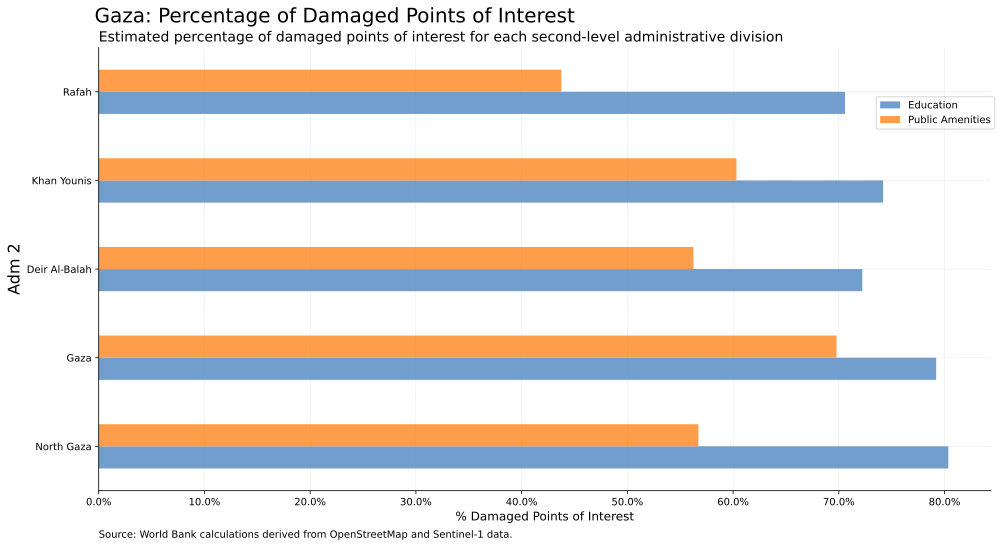

In [115]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.suptitle("Gaza: Percentage of Damaged Points of Interest", y=0.95, fontsize=20, x=0.33)

df.pivot_table("perc", "ADM2_EN", "type", observed=False)[['Education', 'Public Amenities']].plot(
    ax=ax, kind="barh", color=TableauMedium_10.mpl_colors
)

# Add labels and customization
ax.set_xlabel("% Damaged Points of Interest", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))
ax.set_ylabel("Adm 2", fontsize=16)
#ax.set_yticklabels(df["ADM2_EN"].unique(), fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.set_title(
    "Estimated percentage of damaged points of interest for each second-level administrative division",
    fontsize=14,loc='left'
)
ax.text(
    0,
    -0.1,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);